In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as  plt
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('fivethirtyeight')

I read data 

In [43]:
df_train = pd.read_pickle('df_train.pkl')
df_test = pd.read_pickle('df_test.pkl')

TARGET_COLUMN = 'Price'
CATEGORY_COLUMNS = ['DistrictId', 'Rooms', 'Ecology_1', 'Ecology_2', 'Shops_1', 'Helthcare_2', 'Rooms_outlier', 'HouseFloor_outlier',
                   'District_big', 'Floor_category', 'Year_category', 'Healthcare_1_outlier', 'DistrictSize', 'PriceMedian_year', 'PriceMedian_district']
NUMBER_COLUMNS = df_train.columns.drop(CATEGORY_COLUMNS).tolist()
NUMBER_COLUMNS.remove(TARGET_COLUMN)
NUMBER_COLUMNS.remove('Id')

# 3 split df_train on train  and test

In [44]:
df_train.drop(columns='Id', inplace=True)

def split_data(df, share_of_dough):
    x = df.drop(TARGET_COLUMN, axis=1)
    y = df[TARGET_COLUMN]
    return train_test_split(x, y, test_size=share_of_dough, random_state=49)

x_train, x_valid, y_train, y_valid = split_data(df_train, .25)

Random Forest

I used StandardScaler for data scaler

In [45]:
def scale_data(df_train, df_valid, model):
    scaler_model = model
    df_train[NUMBER_COLUMNS] = scaler_model.fit_transform(df_train[NUMBER_COLUMNS])
    df_valid[NUMBER_COLUMNS] = scaler_model.transform(df_valid[NUMBER_COLUMNS])
    return df_train, df_valid, scaler_model

x_train, x_valid, scaler = scale_data(x_train, x_valid, StandardScaler())

# 4 Fit predict model

In [47]:

def evalue_metrics(model):
    predict_train = model.predict(x_train)
    predict_valid = model.predict(x_valid)
    print(r2_score(y_train, predict_train), 'TRAIN', sep='\t')
    print(r2_score(y_valid, predict_valid), 'VALID', sep='\t')
    return predict_train, predict_valid


predict_model = RandomForestRegressor(n_estimators=100, max_depth=5, max_features=16, random_state=49)
predict_model.fit(x_train, y_train)
predict_train, predict_valid = evalue_metrics(predict_model)


# 0.7434277243014902 TRAIN
# 0.700714161180289	VALID

0.7437248986236076	TRAIN
0.6999098351903682	VALID


In [ ]:
x_train.shape
# my_model.model_learn.feature_importances_

c:\users\user\desktop\data-science\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


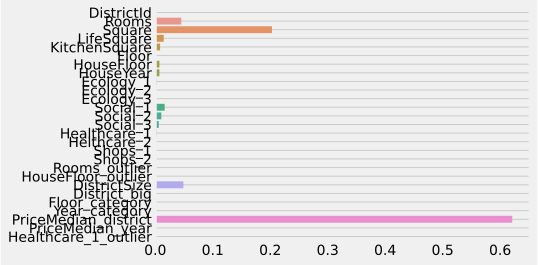

In [48]:
sns.barplot(predict_model.feature_importances_, x_train.columns)
plt.grid()

In [49]:
parameters = [{'n_estimators': [100, 150, 200],
               'max_features': np.arange(16, 20),
               'max_depth': np.arange(4, 7)}]
grid_forest = GridSearchCV(estimator=RandomForestRegressor(random_state=49),
                           param_grid=parameters,
                           scoring='r2',
                           cv=5)

grid_forest.fit(x_train, y_train)
grid_forest.best_params_

# {'max_depth': 6, 'max_features': 19, 'n_estimators': 150}

{'max_depth': 6, 'max_features': 19, 'n_estimators': 150}

In [23]:
grid_forest.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_depth', 'param_max_features', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [50]:

# y_pred_train = grid_forest.predict(x_train)
# r2_score(y_train, y_pred_train)

predict_train, predict_valid = evalue_metrics(grid_forest)

# 0.779417153552581	TRAIN
# 0.719156553551692	VALID

0.779417153552581	TRAIN
0.719156553551692	VALID


### I used forest tree regression, found the best parameters, validation with help r2_score  metric


I use the best model for df_test

In [53]:
test_id = df_test['Id']
df_test.drop(columns='Id', inplace=True)

df_test[NUMBER_COLUMNS] = scaler.transform(df_test[NUMBER_COLUMNS])
predict_test = grid_forest.predict(df_test)

In [56]:

predict_df = pd.DataFrame({'Id': test_id, 'Price': predict_test}, columns=['Id', 'Price'])
predict_df

,Id,Price
0,4567,164255.899790
1,5925,135191.095315
2,960,166457.442618
3,3848,159322.141291
4,746,168412.314698
...,...,...
4995,10379,181984.289312
4996,16138,384436.863117
4997,3912,151290.256704
4998,5722,171788.337928


Save result

In [57]:
predict_df.to_csv('Simakov_Ya_forest_predict.csv', index=False)